In [2]:
# Importing needed packages
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from math import sin, cos, sqrt, atan2, radians

In [3]:
# Getting the locations of all pharmacies in Pisa   
gdf = ox.geometries_from_place("Pisa, Italy", {"healthcare": "pharmacy"})
print(gdf.shape)
gdf.head()

(26, 25)


addr:city addr:housenumber addr:postcode  \
element_type osmid                                                 
node         364741609       Pisa                1         56125   
             366621687       Pisa               6A         56122   
             683846238        NaN              NaN           NaN   
             1501189791       NaN               16           NaN   
             1676239945       NaN                3           NaN   

                                           addr:street   amenity dispensing  \
element_type osmid                                                            
node         364741609                    Corso Italia  pharmacy        yes   
             366621687   Via Giovan Battista Niccolini  pharmacy        NaN   
             683846238                             NaN  pharmacy        NaN   
             1501189791             Piazzale Donatello  pharmacy        yes   
             1676239945             Via Pasquale Pardi  pharmacy        NaN   

                        drive_through healthcare                   name  \
element_type osmid                                                        
node         364741609             no   pharmacy                  Petri   
             366621687             no   pharmacy  Farmacia Comunale n°5   
             683846238            NaN   pharmacy       Farmacia Minucci   
             1501189791           NaN   pharmacy  Farmacia Comunale n°4   
             1676239945           NaN   pharmacy    Farmacia Comunale 1   

                                            opening_hours  ...  \
element_type osmid                                         ...   
node         364741609      Mo-Sa 08:30-13:30,16:00-20:00  ...   
             366621687                               24/7  ...   
             683846238                  Mo-Sa 08:00-20:00  ...   
             1501189791  Mo-Fr 08:00-20:00;Sa 08:00-13:00  ...   
             1676239945                               NaN  ...   

                                          geometry  \
element_type osmid                                   
node         364741609   POINT (10.40136 43.71485)   
             366621687   POINT (10.39223 43.72340)   
             683846238   POINT (10.43092 43.71043)   
             1501189791  POINT (10.37282 43.71158)   
             1676239945  POINT (10.40005 43.70218)   

                                              source wheelchair  \
element_type osmid                                                
node         364741609                           NaN        NaN   
             366621687   PCN aerial 2006;Bing aerial        NaN   
             683846238                           NaN        NaN   
             1501189791                          NaN        NaN   
             1676239945                          NaN        yes   

                        contact:housenumber contact:street contact:city  \
element_type osmid                                                        
node         364741609                  NaN            NaN          NaN   
             366621687                  NaN            NaN          NaN   
             683846238                  NaN            NaN          NaN   
             1501189791                 NaN            NaN          NaN   
             1676239945                 NaN            NaN          NaN   

                        contact:postcode nodes building building:levels  
element_type osmid                                                       
node         364741609               NaN   NaN      NaN             NaN  
             366621687               NaN   NaN      NaN             NaN  
             683846238               NaN   NaN      NaN             NaN  
             1501189791              NaN   NaN      NaN             NaN  
             1676239945              NaN   NaN      NaN             NaN  

[5 rows x 25 columns]

<AxesSubplot:>

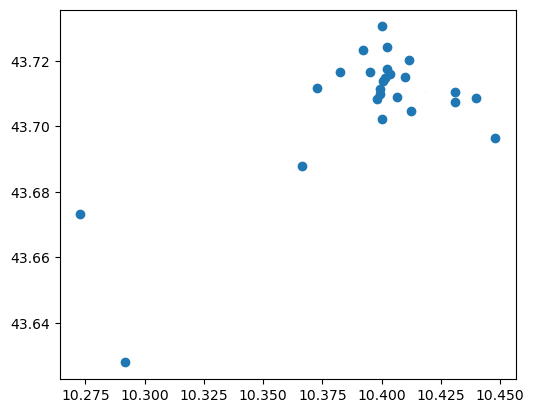

In [4]:
# Plotting their positions
gdf.plot()

In [102]:
# Creating a folium map with centroid on Rome
map_f = folium.Map(location=[43.71485, 10.40136], tiles='Stamen Toner', zoom_start=13)

# Transforming the geopandas DF to geojson, then adding a popup marker to each feature in the geojson, then adding them to the folium map
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,)
folium.features.GeoJsonPopup(fields=['name'], labels=False).add_to(geo_j)
geo_j.add_to(map_f)

folium.Marker(
    location=[43.7188, 10.4234],
    popup="CNR",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(map_f)

folium.Marker(
    location=[43.720443, 10.408081],
    popup="DPC",
    icon=folium.Icon(color="green", icon="info-sign"),
).add_to(map_f)

# Since the previous method to add pop-ups only work for point geometries, we "manually" add the markers associated with polygons
for i in range(0,len(gdf)):
    if gdf.iloc[i]['geometry'].geom_type == "Polygon":
        folium.Marker(
            location=[gdf.iloc[i]['geometry'].centroid.y, gdf.iloc[i]['geometry'].centroid.x],
            popup=gdf.iloc[i]['name'],
            icon=folium.Popup(),
        ).add_to(map_f)       
        
# Plotting the resulting map                       
map_f

In [5]:
# Getting a list for lat, lng and name of each pharmacy in the gdf
lng = []
lat = []
names = []
for i in range(0,len(gdf)):
    if gdf.iloc[i]['geometry'].geom_type == "Point":
        long = gdf.iloc[i]['geometry'].x
        lng.append(long)
        lati = gdf.iloc[i]['geometry'].y
        lat.append(lati)
    else:
        long = gdf.iloc[i]['geometry'].centroid.x
        lng.append(long)
        lati = gdf.iloc[i]['geometry'].centroid.y
        lat.append(lati)
    name = gdf.iloc[i]['name']
    names.append(name)

# Manually adding the location for the CNR and DPC for further computations
names.append('CNR')
lng.append(10.4234)
lat.append(43.7188)
names.append('DPC')
lng.append(10.408081)
lat.append(43.720443)

In [6]:
# Resulting DF with locations of pharmacies and CNR-DPC
pharmacies = pd.DataFrame(list(zip(names, lat, lng)), columns =['name', 'lat', 'lng'])
pharmacies.tail()

,name,lat,lng
23,Farmacia Conticini,43.687992,10.366414
24,Benini,43.673322,10.272865
25,Farmacia D'Igea,43.710367,10.418404
26,CNR,43.718800,10.423400
27,DPC,43.720443,10.408081


In [8]:
# Computing earth distances for every pair of cinemas to find the most central one
names = pharmacies.iloc[:,0].values
latitudes = pharmacies.iloc[:,1].values
longitudes = pharmacies.iloc[:,2].values

latitudes = [radians(i) for i in latitudes]
longitudes = [radians(i) for i in longitudes]

# Approx radius of earth (km)
r = 6371

earth_distances_CNR = [] # empty list for earth distances
# For loop to compute the haversine function on each pharmacy against CNR
for i in range(0,28):
    haversine = r * (2 * atan2(sqrt(sin((latitudes[26] - latitudes[i]) / 2)**2 + cos(latitudes[26]) * cos(latitudes[i]) * sin((longitudes[26] - longitudes[i]) / 2)**2), 
                               sqrt(1 - sin((latitudes[26] - latitudes[i]) / 2)**2 + cos(latitudes[26]) * cos(latitudes[i]) * sin((longitudes[26] - longitudes[i]) / 2)**2)))
    earth_distances_CNR.append(haversine)

for i in range(0,28):
    print("The distance between", names[26], "and", names[i], "=", round(earth_distances_CNR[i],2), "km")

The distance between CNR and Petri = 1.83 km
The distance between CNR and Farmacia Comunale n°5 = 2.56 km
The distance between CNR and Farmacia Minucci = 1.11 km
The distance between CNR and Farmacia Comunale n°4 = 4.14 km
The distance between CNR and Farmacia Comunale 1 = 2.63 km
The distance between CNR and Farmacia Baldacci = 2.18 km
The distance between CNR and Farmacia Comunale n°3 = 0.96 km
The distance between CNR and Farmacia Nuova = 1.64 km
The distance between CNR and Farmacia Comunale N,2 = 2.28 km
The distance between CNR and Farmacia Butali = 3.17 km
The distance between CNR and Farmacia del Carmine = 1.93 km
The distance between CNR and Farmacia Piccinini = 1.72 km
The distance between CNR and Farmacia Raimo = 1.4 km
The distance between CNR and Guglielmino = 2.1 km
The distance between CNR and Pharmastazione = 2.34 km
The distance between CNR and Farmacia Gazzini = 1.8 km
The distance between CNR and Caroti Ghelli = 14.63 km
The distance between CNR and Farmacia San Marc

In [9]:
earth_distances_DPC = [] # empty list for earth distances
# For loop to compute the haversine function on each pharmacy against DPC
for i in range(0,28):
    haversine = r * (2 * atan2(sqrt(sin((latitudes[27] - latitudes[i]) / 2)**2 + cos(latitudes[27]) * cos(latitudes[i]) * sin((longitudes[27] - longitudes[i]) / 2)**2), 
                               sqrt(1 - sin((latitudes[27] - latitudes[i]) / 2)**2 + cos(latitudes[27]) * cos(latitudes[i]) * sin((longitudes[27] - longitudes[i]) / 2)**2)))
    earth_distances_DPC.append(haversine)

for i in range(0,28):
    print("The distance between", names[27], "and", names[i], "=", round(earth_distances_DPC[i],2), "km")

The distance between DPC and Petri = 0.82 km
The distance between DPC and Farmacia Comunale n°5 = 1.32 km
The distance between DPC and Farmacia Minucci = 2.15 km
The distance between DPC and Farmacia Comunale n°4 = 3.0 km
The distance between DPC and Farmacia Comunale 1 = 2.13 km
The distance between DPC and Farmacia Baldacci = 1.38 km
The distance between DPC and Farmacia Comunale n°3 = 0.29 km
The distance between DPC and Farmacia Nuova = 0.62 km
The distance between DPC and Farmacia Comunale N,2 = 1.29 km
The distance between DPC and Farmacia Butali = 4.17 km
The distance between DPC and Farmacia del Carmine = 0.97 km
The distance between DPC and Farmacia Piccinini = 2.85 km
The distance between DPC and Farmacia Raimo = 2.33 km
The distance between DPC and Guglielmino = 1.23 km
The distance between DPC and Pharmastazione = 1.56 km
The distance between DPC and Farmacia Gazzini = 0.62 km
The distance between DPC and Caroti Ghelli = 13.9 km
The distance between DPC and Farmacia San Mar

In [105]:
# Excluding zeroes to get the closest pharmacy to either CNR and DPC
DPC_notzero = [i for i in earth_distances_DPC if i != 0]
CNR_notzero = [i for i in earth_distances_CNR if i != 0]

# Dictionary with cinema name and avg distance
distancePharmacy_DPC = {names[i] : DPC_notzero[i] for i in range(len(DPC_notzero))}  
distancePharmacy_CNR = {names[i] : CNR_notzero[i] for i in range(len(DPC_notzero))}  

# Loop to find the lowest avg distance
for pharmacy, distance in distancePharmacy_DPC.items():
    if distance == np.min(DPC_notzero):
        print("The closest pharmacy to the DPC is:", pharmacy, "with a distance of", round(distance,2), "km")
        
for pharmacy, distance in distancePharmacy_CNR.items():
    if distance == np.min(CNR_notzero):
        print("The closest pharmacy to the CNR is:", pharmacy, "with a distance of", round(distance,2), "km")

The closest pharmacy to the DPC is: Farmacia Comunale n°3 with a distance of 0.29 km
The closest pharmacy to the CNR is: Farmacia Comunale n°3 with a distance of 0.96 km


In [106]:
# create graph from OSM within the boundaries of Pisa
G = ox.graph_from_bbox(43.7400, 43.6918, 10.3601, 10.4477, network_type='walk') #'drive')
# find the nearest node to the start locations (CNR-DPC)
CNR = ox.distance.nearest_nodes(G, pharmacies["lng"][26], pharmacies["lat"][26])
DPC = ox.distance.nearest_nodes(G, pharmacies["lng"][27], pharmacies["lat"][27])
# find the nearest node to the end location (Farmacia Comunale n°3)
Farmacia3 = ox.distance.nearest_nodes(G, pharmacies["lng"][6], pharmacies["lat"][6])

#  find the shortest paths
shortest_route_CNR = nx.shortest_path(G,
                                  CNR,
                                  Farmacia3,
                                  weight='time')
shortest_route_DPC = nx.shortest_path(G,
                                  DPC,
                                  Farmacia3,
                                  weight='time')

In [145]:
# Passing the shortest route to a folium map
route_DPC = ox.plot_route_folium(G, shortest_route_DPC, tiles='Stamen Toner')
route_map = ox.plot_route_folium(G, shortest_route_CNR, route_map=route_DPC , color='Red')

# Adding pop-up markers for points of interest
folium.Marker(
    location=[pharmacies["lat"][26], pharmacies["lng"][26]],
    popup="CNR",
    icon=folium.Icon(color="red"),
).add_to(route_map)

folium.Marker(
    location=[pharmacies["lat"][27], pharmacies["lng"][27]],
    popup="DPC",
    icon=folium.Icon(),
).add_to(route_map)

folium.Marker(
    location=[pharmacies["lat"][6], pharmacies["lng"][6]],
    popup="Farmacia Comunale n° 3",
    icon=folium.Icon(color="green"),
).add_to(route_map)

# Plot final map
route_map